In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)
import mplhep as hep
plt.style.use(hep.style.ROOT)

from scipy.stats import norm
from scipy.optimize import curve_fit

import matplotlib
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras 
#import setGPU
from numpy.random import seed
import tensorflow as tf
from model import model_ConvDNN, model_DNN
from keras import regularizers, Sequential 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import mean_absolute_error, MeanAbsoluteError, mean_squared_error, MeanSquaredError

2022-02-04 11:59:32.925234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-04 11:59:32.925270: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model_outdir = 'CNN_v1_onlywafers'
model_name = 'best_model_DNN'
model_type = 'DNN' 

In [3]:
test_truth = pd.read_hdf('../Preprocessing/truths_0-48k.h5').to_numpy()[40000:48000,3]
test_pred = np.squeeze(np.load('{}/prediction_test_40-48k.npy'.format(model_outdir)))

e_residual_all = test_truth - test_pred

Energy range:  (0, 150)
[3.50607368e-03 6.11750737e+00 5.70253219e+00]
Standard deviation (fit) is 30.55849845466689
Mean (fit) is -1.2822869440816356
Resolution (fit) is -23.83124822077375


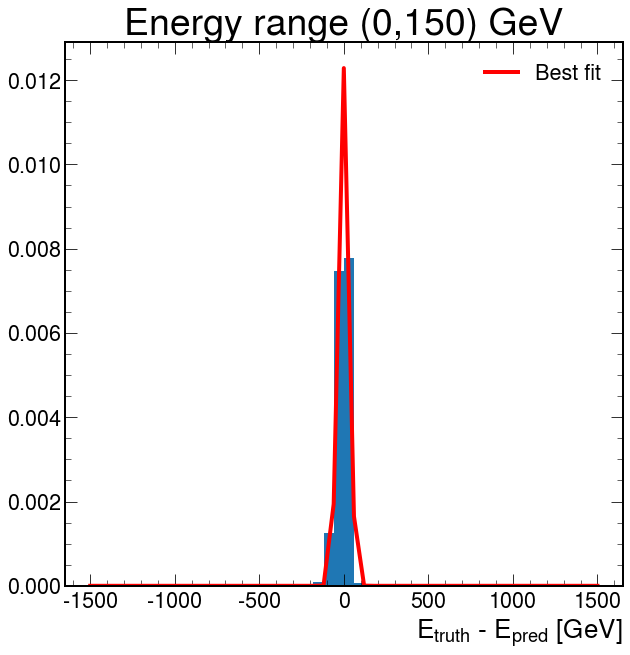

Energy range:  (150, 300)
[7.52801252e-04 6.56145782e+00 4.77262412e+00]
Standard deviation (fit) is 62.4496801845237
Mean (fit) is -19.555787636997987
Resolution (fit) is -3.1934116561162638


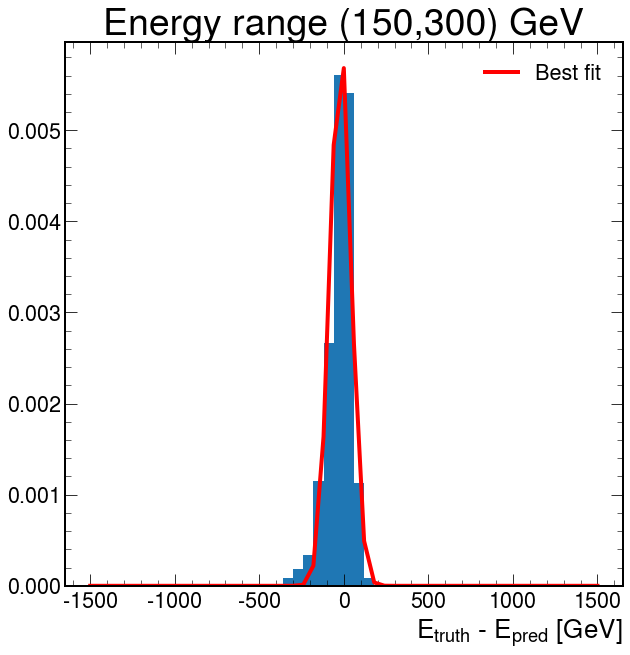

Energy range:  (300, 450)
[3.76405822e-04 9.50179346e+00 7.33429511e+00]
Standard deviation (fit) is 106.59779688625194
Mean (fit) is -39.107598768057414
Resolution (fit) is -2.7257566366697934


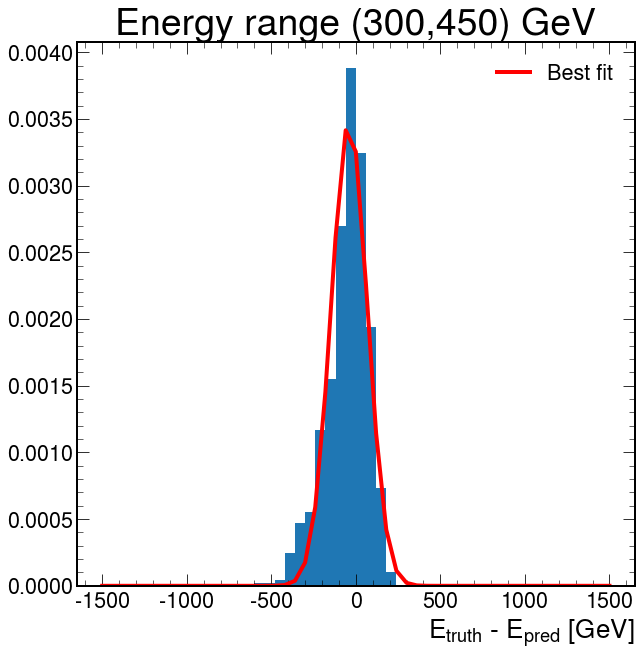

Energy range:  (450, 600)
[2.52132238e-04 1.29082565e+01 9.46000545e+00]
Standard deviation (fit) is 148.7992398574085
Mean (fit) is -83.30636209636224
Resolution (fit) is -1.7861689805310341


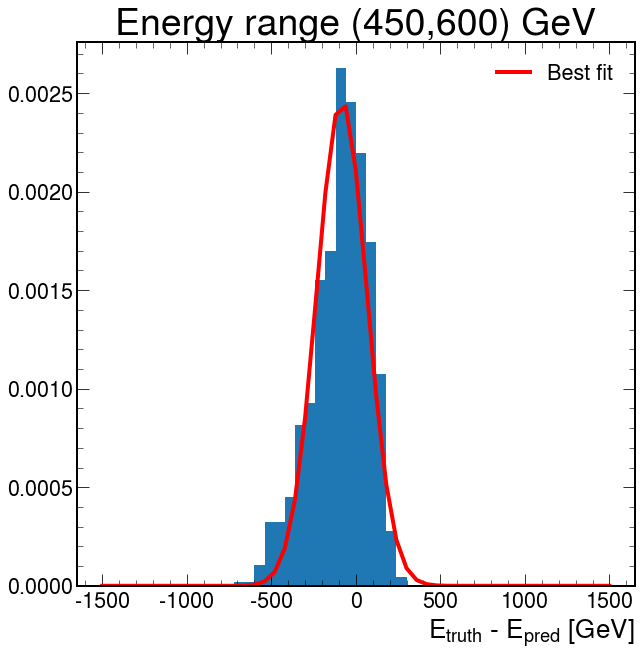

Energy range:  (600, 750)
[1.32757249e-04 8.82515463e+00 6.42972362e+00]
Standard deviation (fit) is 175.47558263393694
Mean (fit) is -69.11947806924859
Resolution (fit) is -2.5387284096406746


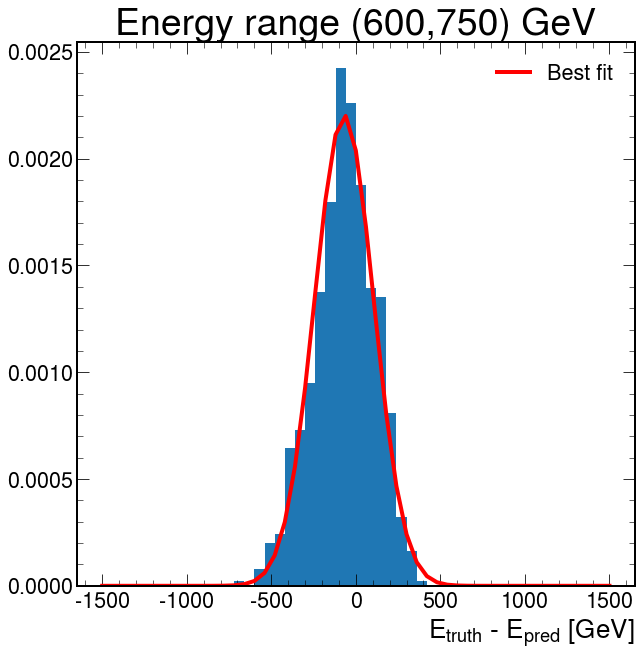

Energy range:  (750, 900)
[1.02576267e-04 8.39926776e+00 6.04533416e+00]
Standard deviation (fit) is 195.2784819332934
Mean (fit) is -40.55503838611075
Resolution (fit) is -4.815147259240967


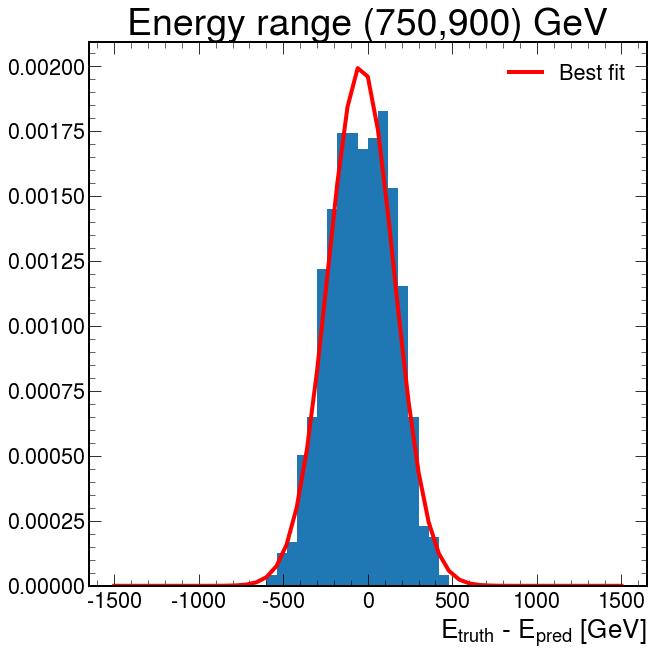

Energy range:  (900, 1050)
[1.46889282e-04 1.06933211e+01 7.85505249e+00]
Standard deviation (fit) is 182.87605002270107
Mean (fit) is -20.978141299619463
Resolution (fit) is -8.717457252803344


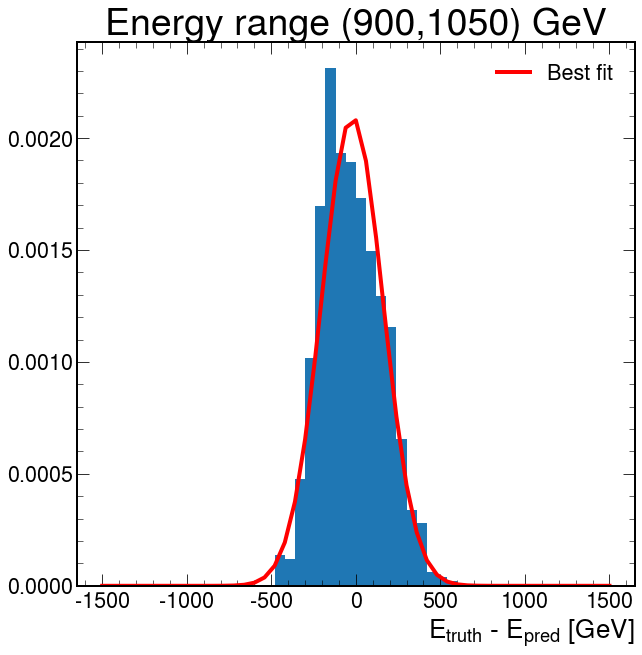

Energy range:  (1050, 1200)
[1.93230162e-04 1.12877164e+01 8.81657500e+00]
Standard deviation (fit) is 163.60605301540375
Mean (fit) is 14.342982350481968
Resolution (fit) is 11.406696948902407


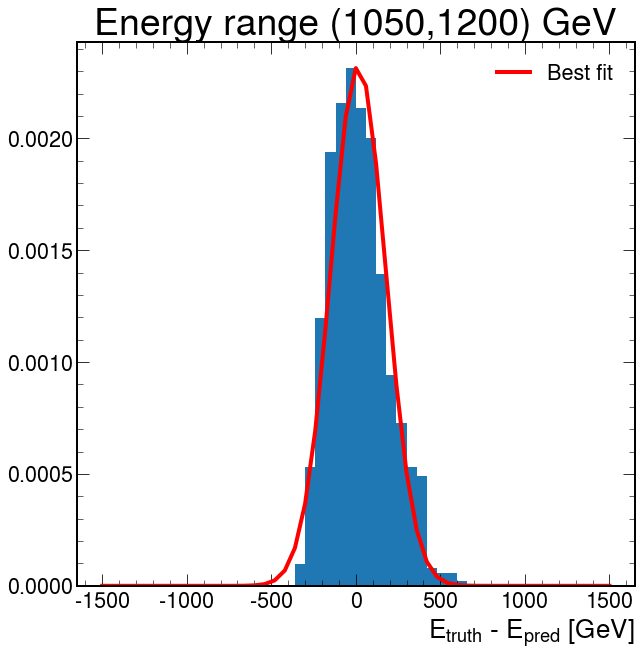

Energy range:  (1200, 1350)
[2.51560293e-04 1.05414220e+01 7.79705509e+00]
Standard deviation (fit) is 136.9139784877257
Mean (fit) is 80.71909088829025
Resolution (fit) is 1.696178400685971


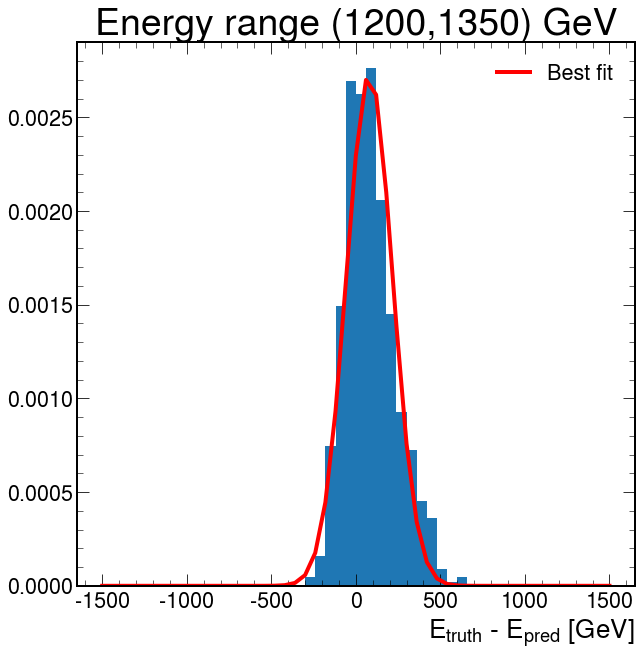

Energy range:  (1350, 1500)
[2.86725030e-04 8.84248299e+00 6.50121216e+00]
Standard deviation (fit) is 117.55356690928659
Mean (fit) is 181.54331097545463
Resolution (fit) is 0.6475235373732954


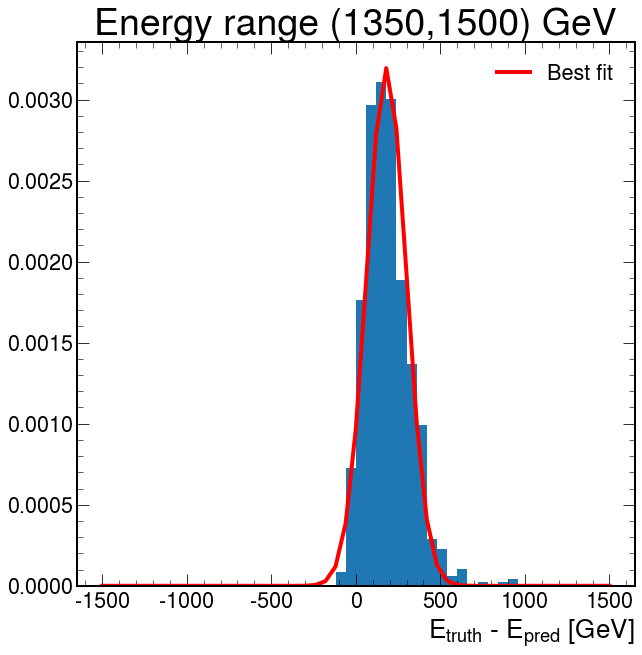

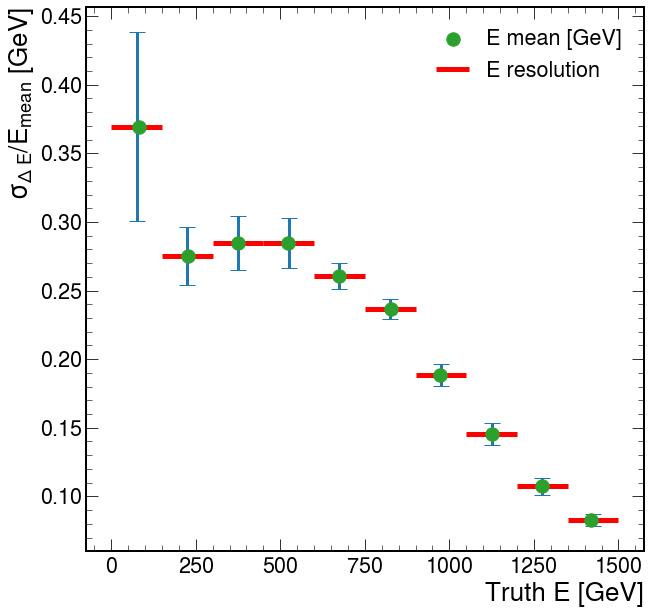

[0.06895930749697539, 0.02104727593873779, 0.019576121456856048, 0.01809314997595059, 0.009541266384240178, 0.007315419555201012, 0.008083749869944607, 0.007837742225925358, 0.006118248222292533, 0.004586685109143561]


In [4]:
#### DIVIDE INTO DIFFERENT ENERGY RANGES
def fit_resolution(emin, emax, emean, e_residual):
    
    E = 1500
    
    plt.hist(e_residual, density = True, bins = 50, range = (-E, E))

    #Fit directly on the histogram
    def fit_function(x, A, mu, sig):
        return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

    bins = np.linspace(-E, E, 51)
    binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
    data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

    mask = data_entries!=0

    #Fit the function to the histogram data.
    popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                        sigma = np.sqrt(data_entries[mask]),
                        absolute_sigma = False, p0=[0.001, 0, 200])

    #Error for parameter estimations
    perr = np.sqrt(np.diag(pcov))
    print(perr)

    std_fit = np.abs(popt[2])
    mean_fit = popt[1]
    res_fit = std_fit/mean_fit
    sigma_res = perr[2]/mean_fit
    print("Standard deviation (fit) is", std_fit)
    print("Mean (fit) is", mean_fit)
    print("Resolution (fit) is {}".format(res_fit))

    #Plot fitted gaussian
    plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
    plt.title("Energy range ({},{}) GeV".format(emin,emax))
    plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
    plt.legend()
    plt.show()

    return std_fit/emean, perr[2]/emean

def plot_res_with_E(e_residual_all, truth_e):
    
    #Data points for plotting
    E_range = []
    E_res = []
    E_err = []
    E_average = []
    
    #Loop through different energy ranges
    for i in range(0,10):
        
        emin = i*150
        emax = (i+1)*150
        
        E_range.append([emin,emax])
        
        print("Energy range: ", (emin,emax))
        
        e_residual = e_residual_all[(truth_e > emin) & (truth_e <= emax)]
        
        emean = np.mean(truth_e[(truth_e > emin) & (truth_e <= emax)])
        E_average.append(emean)
        
        res, err = fit_resolution(emin, emax, emean, e_residual)
        
        E_res.append(res)
        E_err.append(err)
        
    ###### Plot resolution versus energy
    #Plot momentum average
    plt.scatter(E_average, E_res, s=180, c='#2ca02c', label = "E mean [GeV]", zorder = 10)
    
    plt.hlines(E_res,
               [x[0] for x in E_range],
               [x[1] for x in E_range],
               colors='r', lw=5,
               label = 'E resolution',
               linestyles='solid')

    #Plot the error bars
    plt.errorbar([np.average(x) for x in E_range],
                E_res,
                yerr=E_err,
                fmt='none',
                elinewidth=3,
                capsize=8)
    
    plt.xlabel(r'Truth E [GeV]')
    plt.ylabel(r'$\sigma_{\Delta~E}/E_{mean}$ [GeV]')
    
    plt.yrange
    plt.legend()
    plt.show()
    
    #print(E_res)
    print(E_err)
    
    return

plot_res_with_E(e_residual_all, test_truth)

[1.03661598e-04 5.94541933e+00 4.91587298e+00]
Standard deviation (fit) is 167.58128822628194
Mean (fit) is -20.425264293092518
Resolution (fit) is -8.204608068790332


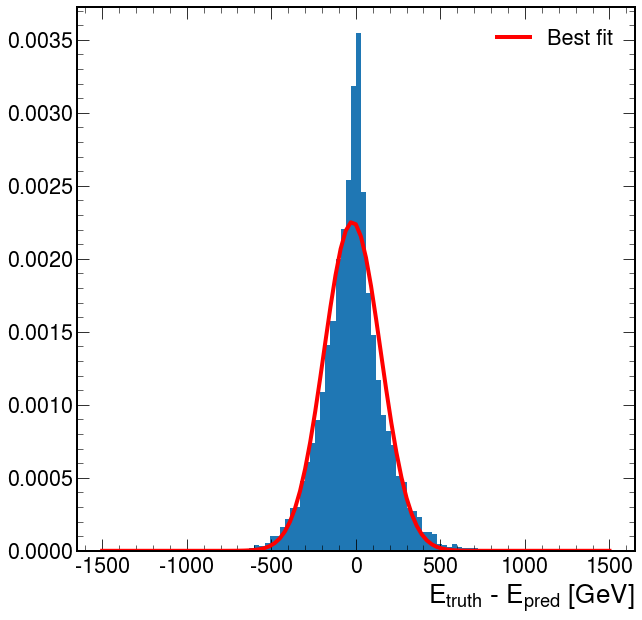

In [9]:
E = 1500

plt.hist(e_residual, density = True, bins = 100, range = (-E,E))

#Fit directly on the histogram
def fit_function(x, A, mu, sig):
    return A*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

bins = np.linspace(-E, E, 101)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
data_entries, _ = np.histogram(e_residual, bins=bins, range = (-E,E), density = True)

mask = data_entries!=0

#Fit the function to the histogram data.
popt, pcov = curve_fit(fit_function, xdata=binscenters[mask], ydata=data_entries[mask],
                    sigma = np.sqrt(data_entries[mask]),
                    absolute_sigma = False, p0=[0.001, 0, 200])

#Error for parameter estimations
perr = np.sqrt(np.diag(pcov))
print(perr)

std_fit = np.abs(popt[2])
mean_fit = popt[1]
res_fit = std_fit/mean_fit
sigma_res = perr[2]/mean_fit
print("Standard deviation (fit) is", std_fit)
print("Mean (fit) is", mean_fit)
print("Resolution (fit) is {}".format(res_fit))

#Plot fitted gaussian
plt.plot(bins, fit_function(bins, *popt), color='red', linewidth=4, label=r'Best fit')
#plt.title("Reconstructed energy distribution for {} MeV e-".format(E))
plt.xlabel(r"$E_{truth}$ - $E_{pred}$ [GeV]")
plt.legend()

plt.show()